In [1]:
run(`gcc dposv_OpenBLAS.c -o dposv_OpenBLAS.so -O3 -march=native -lopenblas -llapacke -shared -fPIC`)
run(`gcc vecLDL_dsyr.c -o vecLDL_dsyr.so -O3 -march=native -lopenblas -shared -fPIC`)
run(`gcc vecLDL_AVX_Unroll.c -o vecLDL_AVX_Unroll.so -O3 -march=native -mavx -shared -fPIC`)

function call_Julia_Linsol(D,V,w)
    u = (Diagonal(D)+V*V')\w
    return u
end

const dposv_OpenBLAS_lib = "./dposv_OpenBLAS.so"
function call_dposv_OpenBLAS(D::Array{Float64,1}, V::Array{Float64,2}, w::Array{Float64,1}, m::Int, n::Int)
    u = Array{Float64,1}(undef,n)
    ccall(
        (:dposv_OpenBLAS, dposv_OpenBLAS_lib),
        Cvoid,
        (Ptr{Cdouble}, Ptr{Cdouble}, Ptr{Cdouble}, Cint, Cint, Ptr{Cdouble}),
        D, V, w, m, n, u
    )
    return u
end

const vecLDL_dsyr_lib = "./vecLDL_dsyr.so"
function call_vecLDL_dsyr(D::Array{Float64,1}, V::Array{Float64,2}, w::Array{Float64,1}, m::Int, n::Int)
    u = Array{Float64,1}(undef,n)
    ccall(
        (:vecLDL_dsyr, vecLDL_dsyr_lib),
        Cvoid,
        (Ptr{Cdouble}, Ptr{Cdouble}, Ptr{Cdouble}, Cint, Cint, Ptr{Cdouble}),
        D, V, w, m, n, u
    )
    return u
end

call_vecLDL_dsyr (generic function with 1 method)

In [2]:
using LinearAlgebra
m = 100
n = 8*m
D = rand(1:1e3,n)
V = rand(n,m)
w = 1e3*(2*rand(n).-1)

u = (Diagonal(D)+V*V')\w

# test dposv_OpenBLAS accuracy
u_dposv_OpenBLAS = call_dposv_OpenBLAS(D,V,w,m,n)
rel_err_dposv_OpenBLAS = norm(u_dposv_OpenBLAS-u)/norm(u)
println("dposv_OpenBLAS rel_err is: $rel_err_dposv_OpenBLAS")

# test vecLDL_dsyr accuracy
u_vecLDL_dsyr = call_vecLDL_dsyr(D,V,w,m,n)
rel_err_vecLDL_dsyr = norm(u_vecLDL_dsyr-u)/norm(u)
println("vecLDL_dsyr rel_err is: $rel_err_vecLDL_dsyr")


dposv_OpenBLAS rel_err is: 5.3848988774205146e-15
vecLDL_dsyr rel_err is: 9.495731444615825e-15


In [3]:
RunTime_dposv = Float64[]
RunTime_vecLDL_dsyr = Float64[]
RunTime_vecLDL_AVX_Unroll = Float64[]

ProbDim = 50:50:500
for m in ProbDim
    n = 8*m
    D = rand(1:1e3,n)
    V = rand(n,m)
    w = 1e3*(2*rand(n).-1)

    num_experiments = ceil(Int, 5000/m)

    # test dposv_OpenBLAS runtime
    start_time = time()
    for i in 1:num_experiments
        u_dposv_OpenBLAS = call_dposv_OpenBLAS(D,V,w,m,n)
    end
    run_time_dposv_OpenBLAS = time() - start_time
    run_time_dposv_OpenBLAS = run_time_dposv_OpenBLAS/num_experiments
    push!(RunTime_dposv,run_time_dposv_OpenBLAS)

    # test vecLDL_dsyr runtime
    start_time = time()
    for i in 1:num_experiments
        u_vecLDL_dsyr = call_vecLDL_dsyr(D,V,w,m,n)
    end
    run_time_vecLDL_dsyr = time() - start_time
    run_time_vecLDL_dsyr = run_time_vecLDL_dsyr/num_experiments
    push!(RunTime_vecLDL_dsyr,run_time_vecLDL_dsyr)
   
end

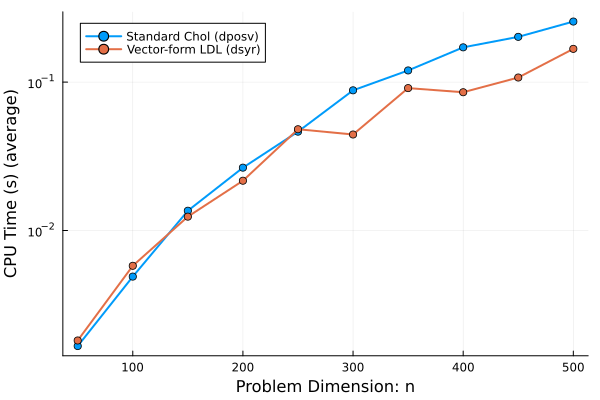

In [4]:
using Plots
plot(ProbDim,RunTime_dposv,marker=:circle,yscale=:log10,lw=2,label="Standard Chol (dposv)")
plot!(ProbDim,RunTime_vecLDL_dsyr,marker=:circle,yscale=:log10,lw=2, label="Vector-form LDL (dsyr)",xlabel="Problem Dimension: n", ylabel="CPU Time (s) (average)",legend=:topleft)


In [5]:
savefig("n_8m_comparision.pdf")

"/home/liang/Documents/L1_SoftMPC_v2/n_8m_comparision.pdf"

In [6]:
RunTime_dposv = Float64[]
RunTime_vecLDL_dsyr = Float64[]
RunTime_vecLDL_AVX_Unroll = Float64[]

ProbDim = 50:50:500
for m in ProbDim
    n = 16*m
    D = rand(1:1e3,n)
    V = rand(n,m)
    w = 1e3*(2*rand(n).-1)

    num_experiments = ceil(Int, 5000/m)

    # test dposv_OpenBLAS runtime
    start_time = time()
    for i in 1:num_experiments
        u_dposv_OpenBLAS = call_dposv_OpenBLAS(D,V,w,m,n)
    end
    run_time_dposv_OpenBLAS = time() - start_time
    run_time_dposv_OpenBLAS = run_time_dposv_OpenBLAS/num_experiments
    push!(RunTime_dposv,run_time_dposv_OpenBLAS)

    # test vecLDL_dsyr runtime
    start_time = time()
    for i in 1:num_experiments
        u_vecLDL_dsyr = call_vecLDL_dsyr(D,V,w,m,n)
    end
    run_time_vecLDL_dsyr = time() - start_time
    run_time_vecLDL_dsyr = run_time_vecLDL_dsyr/num_experiments
    push!(RunTime_vecLDL_dsyr,run_time_vecLDL_dsyr)
end

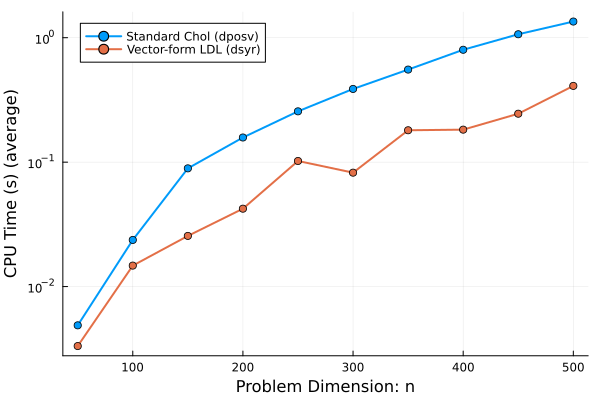

In [7]:
using Plots
plot(ProbDim,RunTime_dposv,marker=:circle,yscale=:log10,lw=2,label="Standard Chol (dposv)")
plot!(ProbDim,RunTime_vecLDL_dsyr,marker=:circle,yscale=:log10,lw=2, label="Vector-form LDL (dsyr)",xlabel="Problem Dimension: n", ylabel="CPU Time (s) (average)",legend=:topleft)

In [8]:
savefig("n_16m_comparision.pdf")

"/home/liang/Documents/L1_SoftMPC_v2/n_16m_comparision.pdf"